In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Helper Functions

In [2]:
def import_data(fn, L):
    maf_array = np.zeros(L)
    with open(fn, 'r') as datafile:
        # Get to the list of mutations
        line = ''
        while not line.startswith('Mutations:'):
            line = datafile.readline()
        # Get the mutations
        while True:
            line = datafile.readline()
            if line.startswith('Genomes:'):
                break
            sline = line.split()
            #print(sline)
            typ = sline[2]
            pos = int(sline[3])
            freq = int(sline[8])
            maf = min(freq, n-freq)
            if typ == 'm0':
                maf_array[pos] = maf
    return(maf_array)

In [3]:
def calc_pi(MAF, n):
    return np.mean(2*(MAF/n)*(n-MAF)/(n-1))

In [4]:
def windowed_pi(MAF, L, window_size, n_samples):
    n_rows = MAF.shape[0]
    n_windows = L // window_size
    PI = np.zeros((n_rows, n_windows))
    for i in range(n_rows):
        for j in range(n_windows):
            i_start = window_size * j
            i_end = window_size * (j+1)
            PI[i, j] = calc_pi(MAF[i, i_start:i_end], n_samples)
    return(PI)

In [5]:
def autocov(x,d):
    if d == 0:
        return np.var(x)
    if x.ndim == 1:
        return np.mean(x[d:]*x[:-d]) - np.mean(x[d:])*np.mean(x[:-d])
    if x.ndim == 2:
        return np.mean(x[:, d:]*x[:, :-d]) - np.mean(x[:, d:])*np.mean(x[:, :-d])
    else:
        return None

# Setup

In [6]:
L = int(1e8)
n = 100
mu_n = 1e-7
r = 1e-8
N = 1e3

In [70]:
#datafn = '../simulations/slim/sweeps2.{}.out'
#datafn = '../simulations/slim/sweeps_fsel-0.0_rep-{}.txt'
#datafn = '../simulations/slim/sweeps_fsel-0.01_rep-{}.txt'
datafn = '../simulations/slim/sweeps_fsel-0.001_rep-{}.txt'

In [71]:
#n_files = 10
#start = 10

#n_files = 8
#start = 1

#n_files = 6
#start = 4

n_files = 9
flist = list(range(4)) + list(range(5,10))

MAF = np.zeros((n_files,L))
for i in range(n_files, L):
#    MAF[i,:] = import_data(datafn.format(i+start))
    MAF[i,:] = import_data(datafn.format(flist[i]))


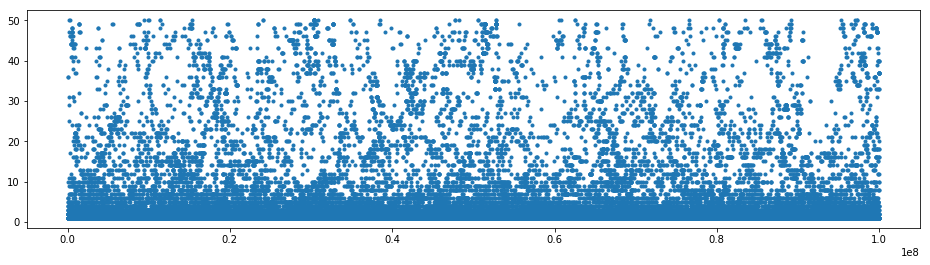

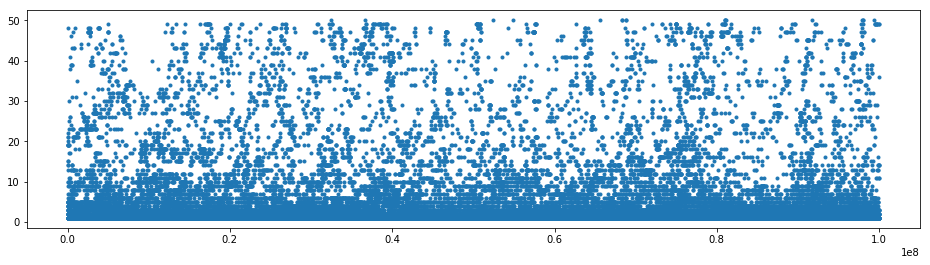

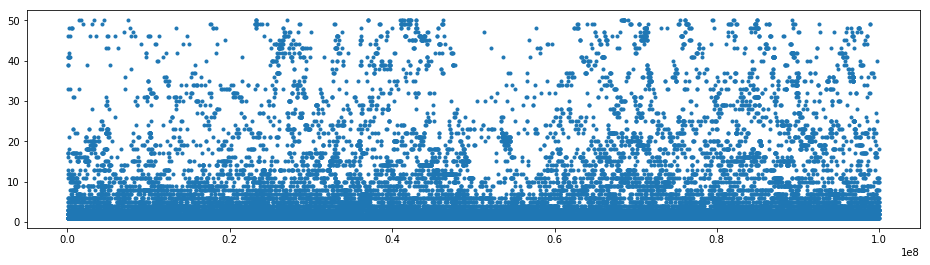

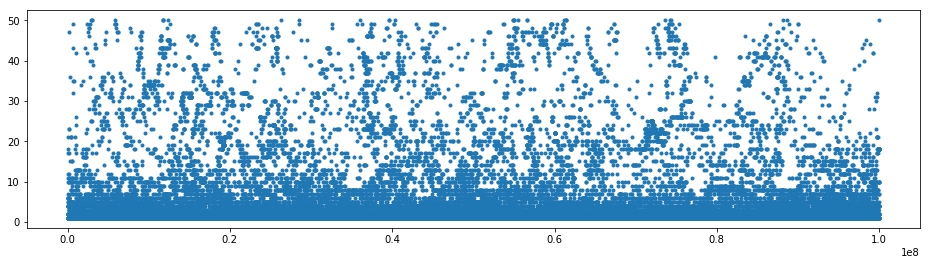

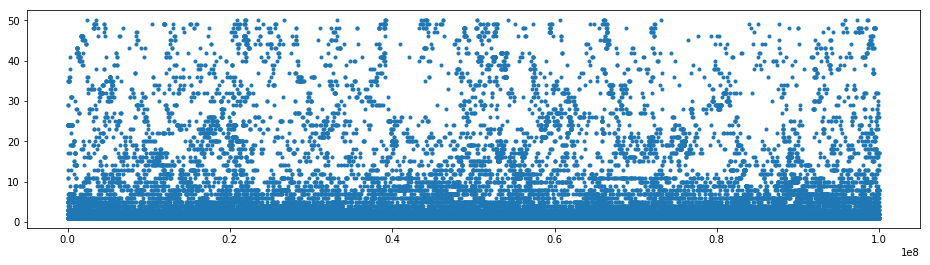

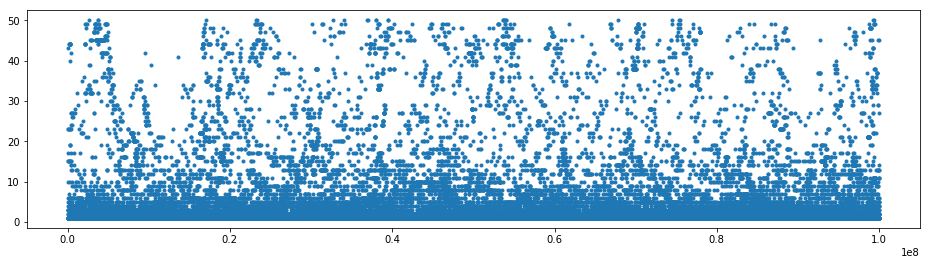

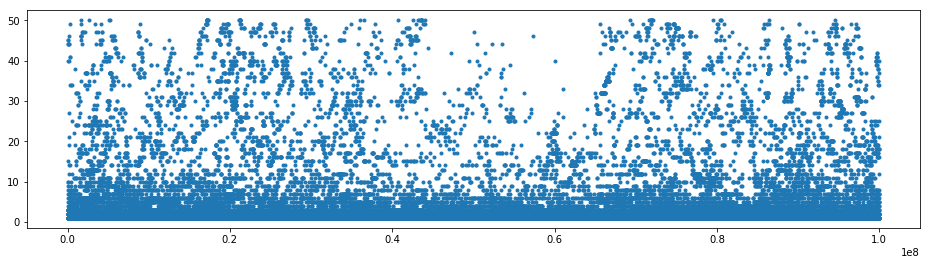

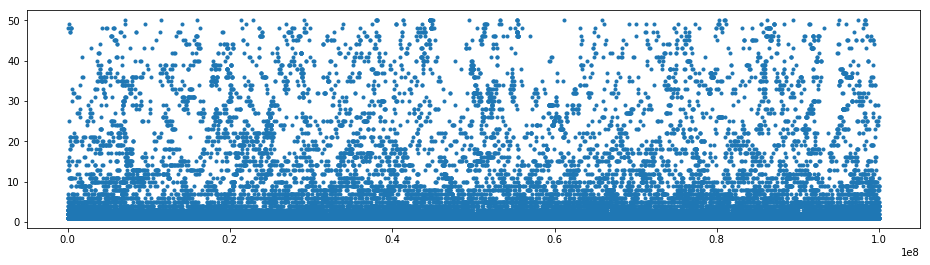

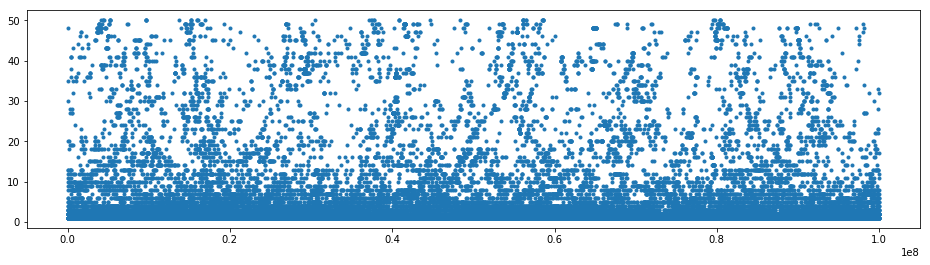

In [72]:
for i in range(n_files):
    plt.figure(figsize=(16,4))
    data = MAF[i,:]
    plt.plot(np.arange(L)[data>0], data[data>0], '.')

In [73]:
f_poly = np.sum(MAF > 0) / (n_files*L)
f_single = np.sum(MAF == 1) / (n_files*L)
f_mult = np.sum(MAF > 1) / (n_files*L)

In [74]:
pi = calc_pi(MAF, n)
pi_0 = 2*mu_n*N

In [75]:
print('Fraction polymorphic:', f_poly)
print('Fraction singleton:', f_single)
print('Fraction multiple:', f_mult)
print('Pi:', pi)
print('Pi/Pi_0:', pi/pi_0)

Fraction polymorphic: 0.000345363333333
Fraction singleton: 0.000132368888889
Fraction multiple: 0.000212994444444
Pi: 3.52518760943e-05
Pi/Pi_0: 0.176259380471


In [76]:
mSFS = np.histogram(MAF, bins=np.arange(n//2 + 2))[0]

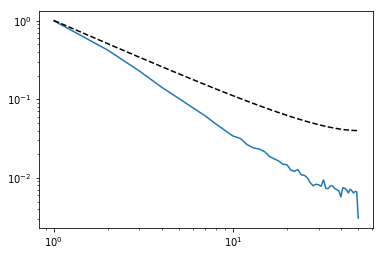

In [77]:
x = np.arange(1, n//2+1)
plt.loglog(x, mSFS[1:]/mSFS[1])
plt.loglog(x, 1/x + 1/(n-x), 'k--')

# $\pi$

In [78]:
w_superfine = 1000
w_fine = 10000
w_coarse = 1000000
PI_superfine = windowed_pi(MAF, L, w_superfine, n)
PI_fine = windowed_pi(MAF, L, w_fine, n)
PI_coarse = windowed_pi(MAF, L, w_coarse, n)

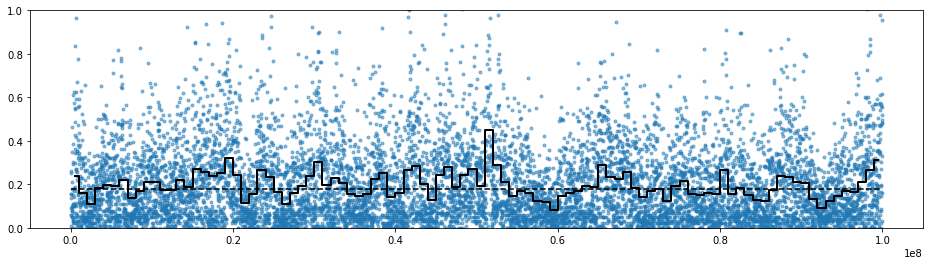

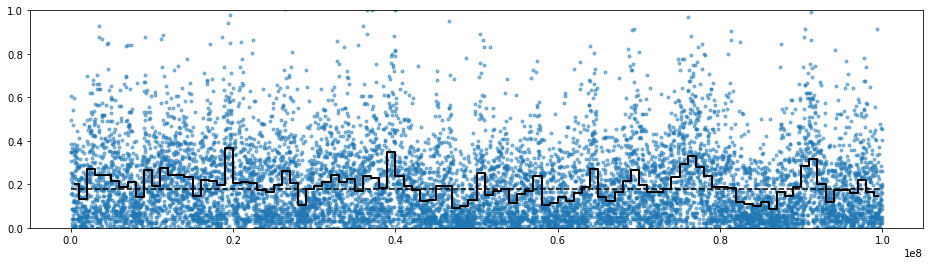

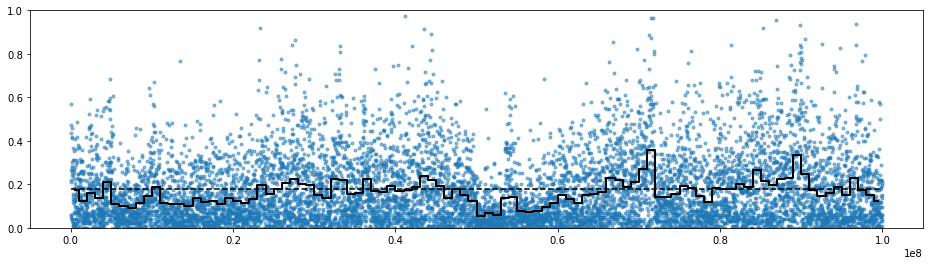

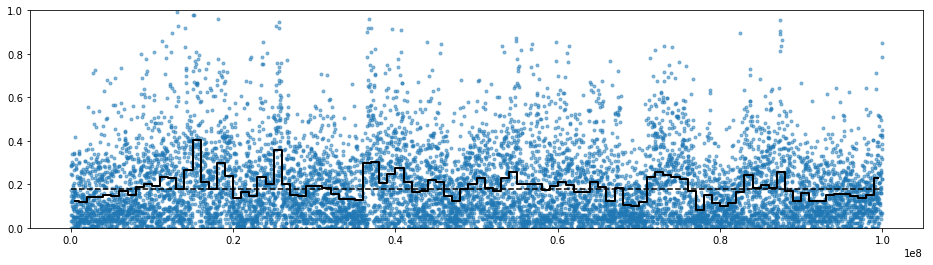

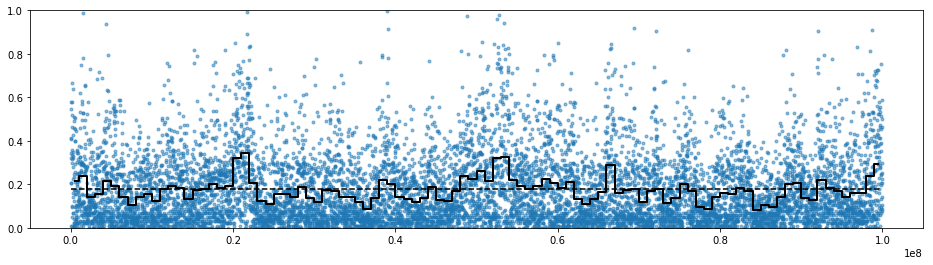

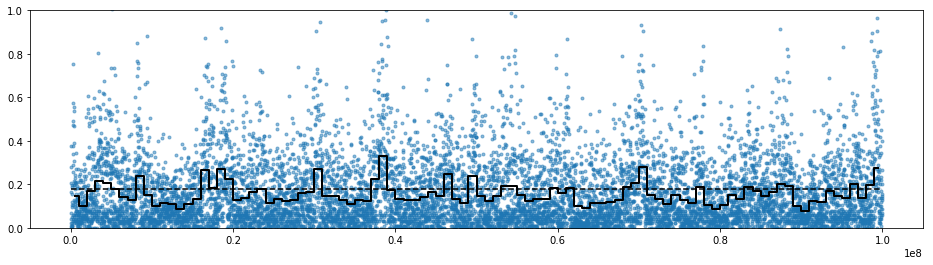

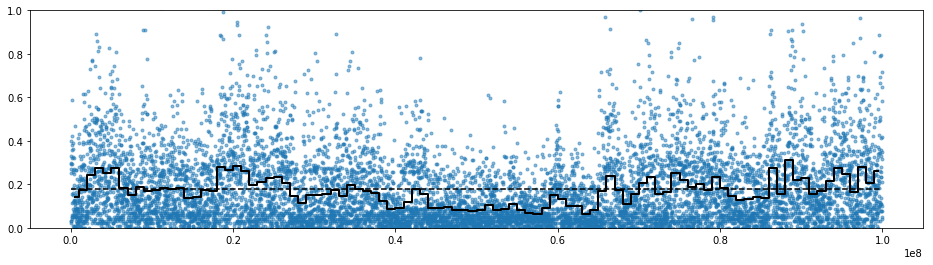

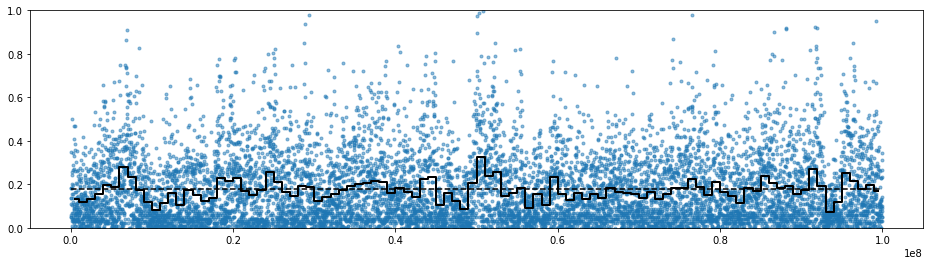

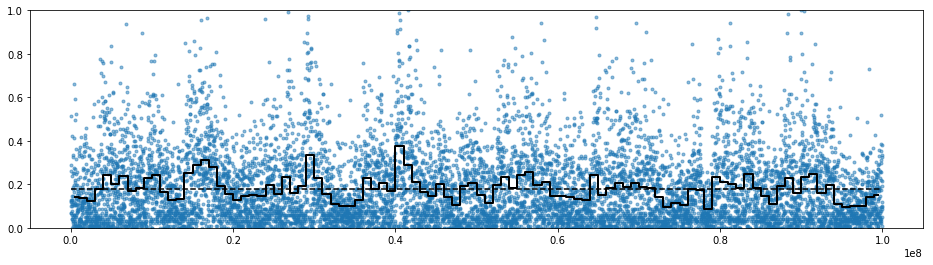

In [79]:
for i in range(n_files):
    plt.figure(figsize=(16,4))
    plt.plot(w_fine*(np.arange(L//w_fine) + 1/2), PI_fine[i,:]/pi_0, '.', alpha=0.5)
    plt.plot(w_coarse*(np.arange(L//w_coarse) + 1/2), PI_coarse[i,:]/pi_0, '-k', lw=2, drawstyle='steps-mid')
    plt.hlines(pi/pi_0, 0, L, linestyle='dashed', zorder=4)
    #plt.ylim([0,4])
    plt.ylim([0,1])

In [80]:
D_fine = np.arange(0, 9001, 1)
AC_fine = np.array([autocov(PI_fine, d) for d in D_fine])

(-0.1, 1.1)

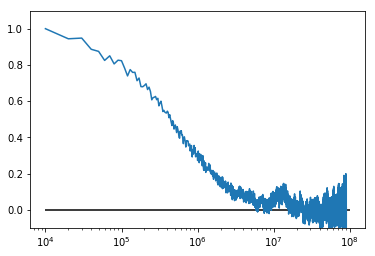

In [81]:
plt.semilogx(D_fine*w_fine, AC_fine/AC_fine[1])
plt.hlines(0, w_fine, L)
plt.ylim([-.1,1.1])

In [82]:
D_superfine = np.arange(0, 9001, 1)
AC_superfine = np.array([autocov(PI_superfine, d) for d in D_superfine])

(-0.1, 1.1)

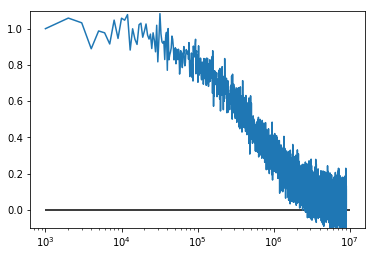

In [83]:
plt.semilogx(D_superfine*w_superfine, AC_superfine/AC_superfine[1])
plt.hlines(0, w_superfine, L/10)
plt.ylim([-.1,1.1])

(-0.1, 1.1)

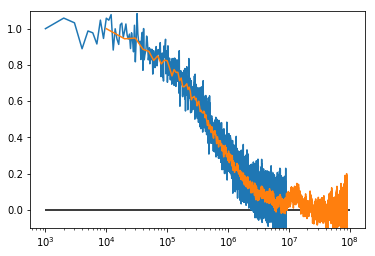

In [84]:
plt.semilogx(D_superfine*w_superfine, AC_superfine/AC_superfine[1])
plt.semilogx(D_fine*w_fine, AC_fine/AC_fine[1])
plt.hlines(0, w_superfine, L)
plt.ylim([-.1,1.1])

# SFS covar

In [85]:
def windowed_singletons(MAF, L, window_size):
    n_rows = MAF.shape[0]
    n_windows = L // window_size
    singles = np.zeros((n_rows, n_windows))
    non_singles = np.zeros((n_rows, n_windows))
    for i in range(n_windows):
        i_start = window_size * i
        i_end = window_size * (i+1)
        window = MAF[:, i_start:i_end]
        singles[:, i] = np.sum(window == 1, axis=1) / window_size
        non_singles[:, i] = np.sum(window > 1, axis=1) / window_size
    return singles, non_singles

In [86]:
SINGLES_superfine, NONSINGLES_superfine = windowed_singletons(MAF, L, w_superfine)
SINGLES_fine, NONSINGLES_fine = windowed_singletons(MAF, L, w_fine)
SINGLES_coarse, NONSINGLES_coarse = windowed_singletons(MAF, L, w_coarse)

In [87]:
def lag_cov(X1, X2, d):
    if d == 0:
        return np.cov(np.ravel(X1), np.ravel(X2))[0,1]
    else:
        return np.cov(np.ravel(X1[:,:-d]), np.ravel(X2[:,d:]))[0,1]        

In [88]:
cov_fine = np.array([lag_cov(SINGLES_fine, NONSINGLES_fine, d) for d in D_fine])

In [89]:
cov_superfine = np.array([lag_cov(SINGLES_superfine, NONSINGLES_superfine, d) for d in D_superfine])

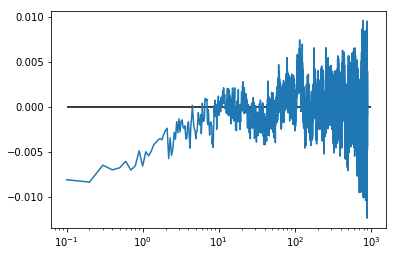

In [35]:
plt.semilogx(D_fine*w_fine, cov_fine/(f_single*f_mult))
plt.hlines(0, w_fine, L)

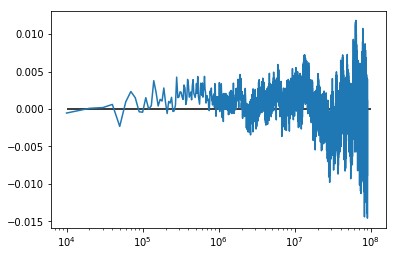

In [40]:
plt.semilogx(D_fine*w_fine, cov_fine/(f_single*f_mult))
plt.hlines(0, w_fine, L)

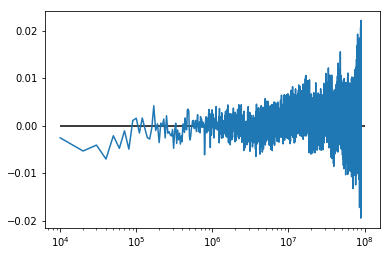

In [90]:
plt.semilogx(D_fine*w_fine, cov_fine/(f_single*f_mult))
plt.hlines(0, w_fine, L)

(-0.01, 0.01)

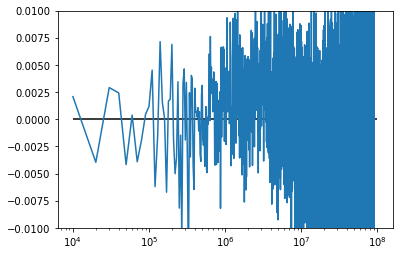

In [61]:
plt.semilogx(D_fine*w_fine, cov_fine/(f_single*f_mult))
plt.hlines(0, w_fine, L)
plt.ylim([-0.01,0.01])

(-0.01, 0.01)

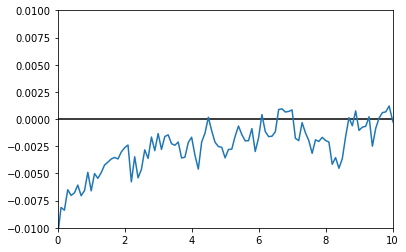

In [33]:
plt.plot(N*r*D_fine*w_fine, cov_fine/(f_single*f_mult))
plt.hlines(0, 0, 10)
plt.xlim([0,10])
plt.ylim([-0.01, 0.01])

(-0.005, 0.005)

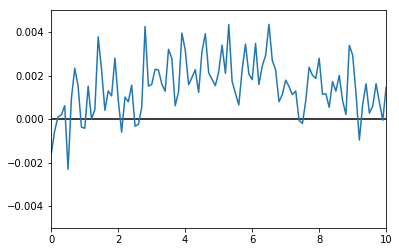

In [54]:
plt.plot(N*r*D_fine*w_fine, cov_fine/(f_single*f_mult))
plt.hlines(0, 0, 10)
plt.xlim([0,10])
plt.ylim([-0.005, 0.005])

(-0.005, 0.005)

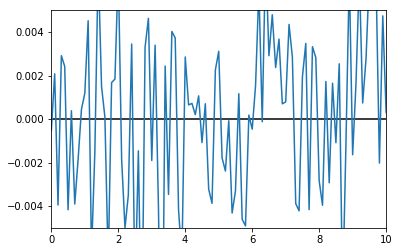

In [62]:
plt.plot(N*r*D_fine*w_fine, cov_fine/(f_single*f_mult))
plt.hlines(0, 0, 10)
plt.xlim([0,10])
plt.ylim([-0.005, 0.005])

(-0.005, 0.005)

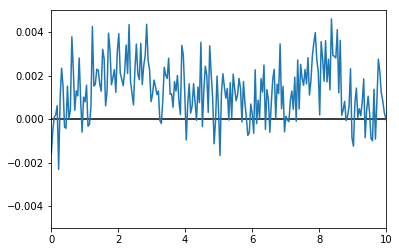

In [58]:
plt.plot(r*pi/(2*mu_n)*D_fine*w_fine, cov_fine/(f_single*f_mult))
plt.hlines(0, 0, 10)
plt.xlim([0,10])
plt.ylim([-0.005, 0.005])

(-0.005, 0.005)

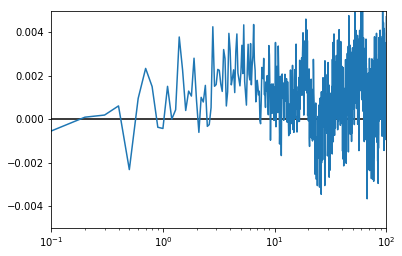

In [61]:
plt.semilogx(N*r*D_fine*w_fine, cov_fine/(f_single*f_mult))
plt.hlines(0, .1, L)
plt.xlim([0.1, 100])
plt.ylim([-0.005, 0.005])

(-0.005, 0.005)

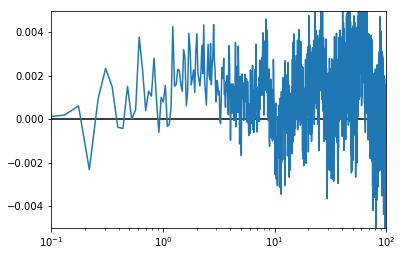

In [62]:
plt.semilogx(r*pi/(2*mu_n)*D_fine*w_fine, cov_fine/(f_single*f_mult))
plt.hlines(0, .1, L)
plt.xlim([0.1, 100])
plt.ylim([-0.005, 0.005])